In [1]:
import os
import pickle
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.jit
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from support import *

In [2]:
results = [pickle.load(open(f, 'rb')) for f in glob('./result-50p/*.pkl')]
results = [item for sublist in results for item in sublist]

In [3]:
broad_words = set([word for r in results for word in r.broad_words])
narrow_words = set([word for r in results for word in r.narrow_words])
broad_words_toi = {word: i for i, word in enumerate(broad_words)}
narrow_words_toi = {word: i for i, word in enumerate(narrow_words)}
broad_words_ito = {i: word for word, i in broad_words_toi.items()}
narrow_words_ito = {i: word for word, i in narrow_words_toi.items()}
# pickle.dump(broad_words_toi, open('broad_words_toi.pkl', 'wb'))
# pickle.dump(narrow_words_toi, open('narrow_words_toi.pkl', 'wb'))

In [4]:
samples = torch.load('samples.pt')
# dataloader = DataLoader(samples, batch_size=128, shuffle=True)
samples.__len__(), len(broad_words), len(narrow_words)

(14472, 127, 608)

In [5]:
class Model(nn.Module):
    def __init__(self, n_broad, n_narrow):
        super(Model, self).__init__()
        self.broad = nn.Sequential(
            nn.Linear(n_broad, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.narrow = nn.Sequential(
            nn.Linear(n_narrow, 300),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 75),
            nn.ReLU(),
            nn.Linear(75, 32),
        )
        self.combined = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.ReLU(),
        )

    def forward(self, broad, narrow):
        broad = self.broad(broad)
        narrow = self.narrow(narrow)
        combined = torch.cat((broad, narrow), dim=1)
        return self.combined(combined)
    
model = Model(len(broad_words), len(narrow_words))
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [6]:
model.load_state_dict(torch.load('model1.pt'))
model.eval()

Model(
  (broad): Sequential(
    (0): Linear(in_features=127, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (narrow): Sequential(
    (0): Linear(in_features=608, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=75, bias=True)
    (5): ReLU()
    (6): Linear(in_features=75, out_features=32, bias=True)
  )
  (combined): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [7]:
model(torch.ones(1, len(broad_words)), torch.ones(1, len(narrow_words))) * 45000

tensor([[77032.4062]], grad_fn=<MulBackward0>)

In [8]:
model(torch.ones(1, len(broad_words)) * -1, torch.ones(1, len(narrow_words)) * -1) * 45000

tensor([[0.]], grad_fn=<MulBackward0>)

In [9]:
values = []
for broad, narrow, result in tqdm(samples):
    with torch.no_grad():
        pred = model(broad.unsqueeze(0), narrow.unsqueeze(0))
    values.append((pred.item() * 45000, result.item()))

  0%|          | 0/14472 [00:00<?, ?it/s]

In [10]:
x = [v[0] for v in values]
y = [v[1] for v in values]

<Axes: >

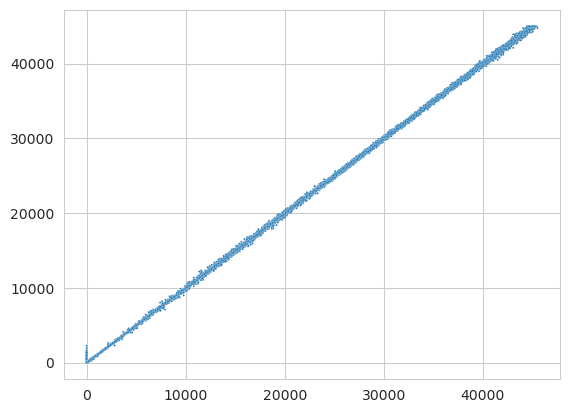

In [12]:
sns.scatterplot(x=x, y=y, s=[2]*len(x))